In [1]:
import mxnet as mx
import numpy as np
import scipy as sp
import sys
import networkx as nx
import logging
import time
import matplotlib.pyplot as plt
import math
import inspect

from autoencoder import AutoEncoderModel
from autoencoder_cl import train_cl
from autoencoder_cl import get_densest

In [12]:
def train(data, y, num_dims, num_epoc, internal_act=None, loss_name="L2", learning_rate=0.005,
          batch_size=50, debug=False, return_err=False, proj=None, use_sparse=False, plot=True):
    model = AutoEncoderModel(data, y, num_dims, internal_act, learning_rate, batch_size,
                             loss_name, proj=proj, use_sparse=use_sparse)
    params = model.train(data, y, num_epoc, debug=debug, return_err=return_err, plot=plot)
    if (return_err):
        params = params[0]
    _, _, tot_loss = model.numpy_cal(params)
    print("The error: " + str(tot_loss))
    return params

## Run on a low-rank data

In [13]:
rand_data1 = mx.ndarray.random_uniform(shape=[1000, 10])
rand_data2 = mx.ndarray.random_uniform(shape=[10, 100])
rand_data = mx.ndarray.dot(rand_data1, rand_data2)
print("max: " + str(mx.ndarray.max(rand_data)))
rand_data = rand_data / mx.ndarray.max(rand_data)
print(rand_data.shape)

max: 
[5.3362155]
<NDArray 1 @cpu(0)>
(1000L, 100L)


In [4]:
np_rand_data = rand_data.asnumpy()
U, s, Vh = sp.sparse.linalg.svds(np_rand_data, k=10)
low_dim_data = np.dot(np_rand_data, Vh.T)
print(low_dim_data)
print(sum(low_dim_data[low_dim_data > 0]))
print(sum(low_dim_data[low_dim_data < 0]))
res = np.dot(low_dim_data, Vh)
print("svd error: " + str(np.sum(np.square(res - np_rand_data))))

[[ 0.18948181  0.06058291  0.31489348 ... -0.01877208 -0.20903039
   5.7033825 ]
 [ 0.08596598 -0.14269124 -0.18132016 ... -0.04427027 -0.01777934
   4.493879  ]
 [ 0.1588278   0.12368675 -0.09298901 ... -0.31246293  0.06991608
   4.061795  ]
 ...
 [-0.0979356  -0.07024899  0.01844578 ... -0.21295373 -0.05938913
   5.9068613 ]
 [-0.1953762   0.2887378   0.03041264 ...  0.3102496   0.18088539
   4.1224356 ]
 [ 0.02635321 -0.03082476 -0.01648201 ...  0.3190525  -0.24001133
   4.4862766 ]]
5229.299716993824
-558.4793925720987
svd error: 2.3435584e-08


loss func: L2
Learning rate: 4
batch size: 100
internal #epochs: 400
reinit optimizer. New learning rate: 2


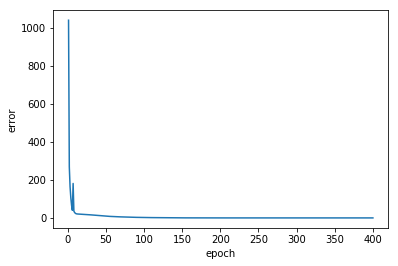

In [5]:
params_linear_r10=train(rand_data, rand_data, 10, 400, learning_rate=4, batch_size=100)

Internal activation: relu
loss func: L2
Learning rate: 1
batch size: 100
internal #epochs: 1000


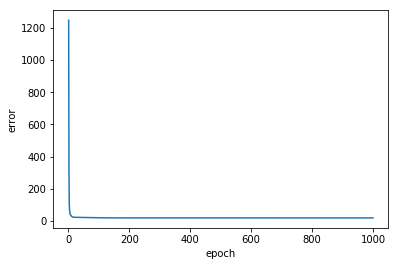

In [6]:
params_sigmoid_r10=train(rand_data, rand_data, 10, 1000, internal_act='relu', learning_rate=1, batch_size=100)

## Run on real data

We compute the embedding on a graph with 81306 vertices and 1768149 vertices. To embed the graph into 10 dimensions, we start with the most densest columns and increase the number of columns to embed. When we increase the number of columns to embed, we use the parameters trained from the previous run (on the dataset with a smaller number of columns).

In [3]:
elg = nx.read_edgelist("/home/ubuntu/datasets/twitter_combined.txt", create_using=nx.DiGraph())
spm = nx.to_scipy_sparse_matrix(elg, dtype='f')

There are 81306 vertices.


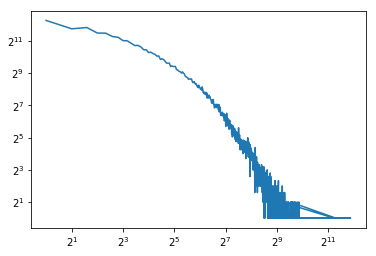

In [4]:
def deg_loglog(g):
    from collections import Counter
    nx_deg = nx.degree(g)
    deg = []
    for n, d in nx_deg:
        deg.append(d)
    cnt = Counter(deg)
    print('There are ' + str(sum(cnt.values())) + ' vertices.')
    plt.loglog(cnt.keys(), cnt.values(), basex=2, basey=2)
    plt.show()
    
deg_loglog(elg)

### Curriculum learning

With curriculum learning, we can take advantage of the computation results from the denser columns.
To some extent, curriculum learning provides a new way of initializing the parameters of a neural network. We take the parameters from the neural network trained for the denser columns of a graph to initialize the neural network for the dataset with more columns.

### Compute the embedding on the densest 8000 columns.

In [10]:
sp_data = get_densest(spm, 8000)
data = mx.ndarray.sparse.csr_matrix(sp_data)
print(data.shape)

(81306L, 8142L)


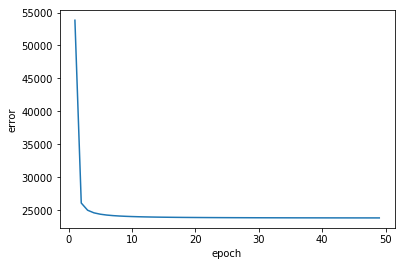

The error: 969367.0
958.084613085


In [13]:
start = time.time()
params = train(data, data, 100, 50, internal_act='relu', learning_rate=16, batch_size=2000)
print(time.time() - start)

### Train an autoencoder with curriculum learning

Below we run experiments with different configurations.
* Whether to approximate loss (`approx_loss`)
* How aggressively increase the number of input and hidden dimensions (`num_incs`). Larger `num_incs` increases less aggressively.
* How many iterations to train for each given (input and hidden) dimension.

Approximating loss not only reduces the training time almost by a factor of 3, but also significantly helps reduce the loss.

Increasing the number of input and hidden dimensions less aggressively can reduce the loss, but by a very small margin. Therefore, we should use a small `num_incs` to speedup.

Another finding is that we don't need many iterations to train for each dimension. Instead, we should use a larger learning rate to decrease the loss with a small number of iterations.

#dims increase by a factor of 1.70163774632
#red dims increase by 8.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
#dims: 68
reduce #dims to 28
svd error: 24241.1
It takes 8.70959687233 seconds
The error: 25353.6
The original error: 910725.0

#dims: 115
reduce #dims to 36
svd error: 39476.6
It takes 13.0966479778 seconds
The error: 40385.8
The original error: 893271.0

#dims: 195
reduce #dims to 44
svd error: 61229.4
It takes 19.9300780296 seconds
The error: 62289.0
The original error: 874960.0

#dims: 331
reduce #dims to 52
svd error: 91176.4
It takes 31.0165579319 seconds
The error: 92436.5
The original error: 854173.0

#dims: 563
reduce #dims to 60
svd error: 133043.0
It takes 52.0139808655 seconds
The error: 134591.0
The original error: 829566.0

#dims: 958
reduce #dims to 68
svd error: 191241.0
It takes 94.5422449112 seconds
The error: 192194.0
The original error: 799946.0

#dims: 1630
reduce #dims to 76
svd error: 261971.0
It takes 160.923809052 seconds
The error: 263183.0
The

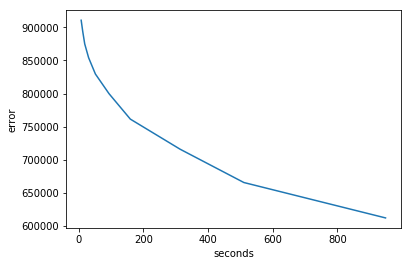

<autoencoder.AutoEncoderModel instance at 0x7f1d87f46cf8>

In [7]:
train_cl(spm, 8000, 100, 50, num_incs=10, learning_rate=16)

#dims increase by a factor of 1.70163774632
#red dims increase by 8.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
#dims: 68
reduce #dims to 28
svd error: 24241.1
It takes 6.95019698143 seconds
The error: 24313.2
The original error: 909615.0

#dims: 115
reduce #dims to 36
svd error: 39476.6
It takes 8.99090790749 seconds
The error: 39550.0
The original error: 892570.0

#dims: 195
reduce #dims to 44
svd error: 61229.4
It takes 11.1957218647 seconds
The error: 61360.7
The original error: 874414.0

#dims: 331
reduce #dims to 52
svd error: 91176.4
It takes 14.4939730167 seconds
The error: 91416.9
The original error: 853236.0

#dims: 563
reduce #dims to 60
svd error: 133043.0
It takes 18.8100409508 seconds
The error: 133125.0
The original error: 828303.0

#dims: 958
reduce #dims to 68
svd error: 191241.0
It takes 26.3912189007 seconds
The error: 191400.0
The original error: 799336.0

#dims: 1630
reduce #dims to 76
svd error: 261971.0
It takes 38.0738949776 seconds
The error: 262175.0
The

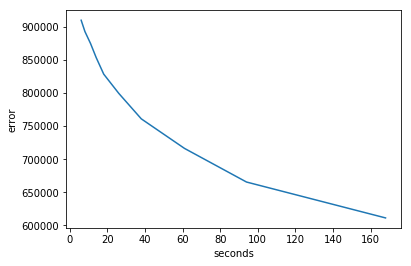

<autoencoder.AutoEncoderModel instance at 0x7f1d51780248>

In [6]:
train_cl(spm, 8000, 100, 50, num_incs=10, learning_rate=16, approx_loss=True)

#dims increase by a factor of 1.69864646463
#red dims increase by 8.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0


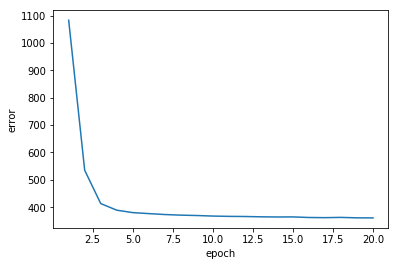

#dims: 67
reduce #dims to 28
svd error: 23735.0

Approximate loss with 42 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0


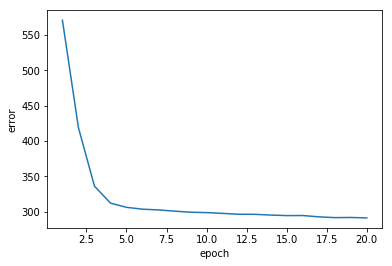

It takes 3.94127106667 seconds
The error: 23923.1

#dims: 113
reduce #dims to 36
svd error: 38571.8

Approximate loss with 54 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0


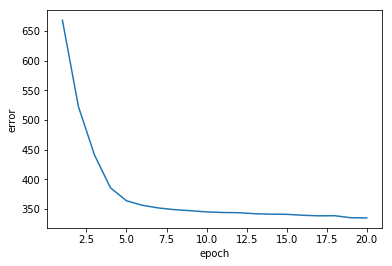

It takes 5.12054800987 seconds
The error: 38838.1

#dims: 191
reduce #dims to 44
svd error: 60142.5

Approximate loss with 66 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0


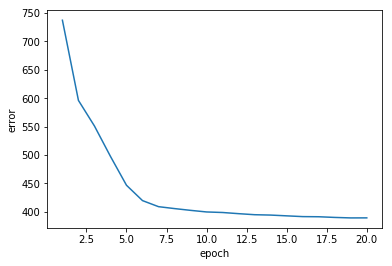

It takes 6.28332400322 seconds
The error: 60567.2

#dims: 324
reduce #dims to 52
svd error: 89254.5

Approximate loss with 78 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0


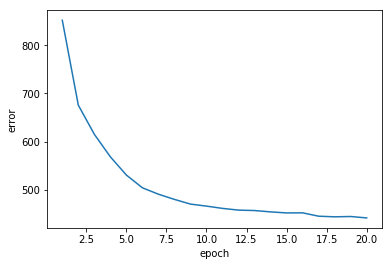

It takes 8.04566812515 seconds
The error: 89765.2

#dims: 550
reduce #dims to 60
svd error: 130925.0

Approximate loss with 90 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0


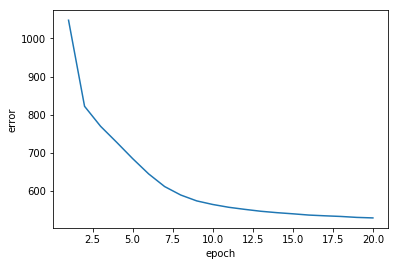

It takes 9.82427692413 seconds
The error: 132063.0

#dims: 934
reduce #dims to 68
svd error: 187582.0

Approximate loss with 102 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 32.0


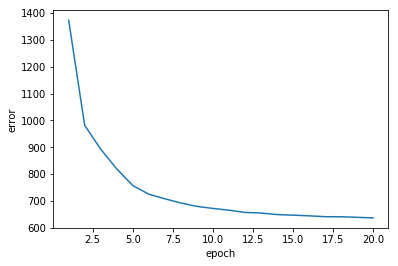

It takes 12.6482591629 seconds
The error: 189646.0

#dims: 1586
reduce #dims to 76
svd error: 256351.0

Approximate loss with 114 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 64.0


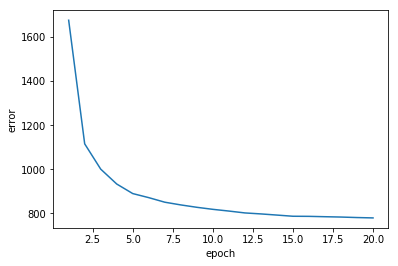

It takes 17.9286029339 seconds
The error: 258737.0

#dims: 2694
reduce #dims to 84
svd error: 343786.0

Approximate loss with 126 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0


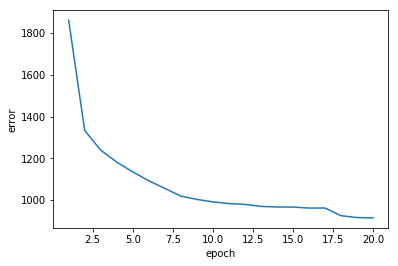

It takes 21.5947158337 seconds
The error: 346021.0

#dims: 4576
reduce #dims to 92
svd error: 458074.0

Approximate loss with 138 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0


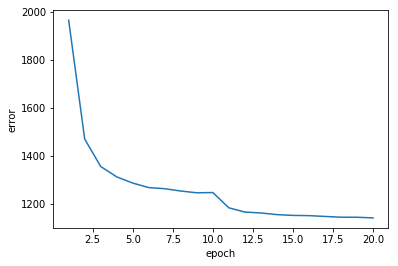

It takes 29.9917011261 seconds
The error: 461704.0

#dims: 7773
reduce #dims to 100
svd error: 602304.0

Approximate loss with 150 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0


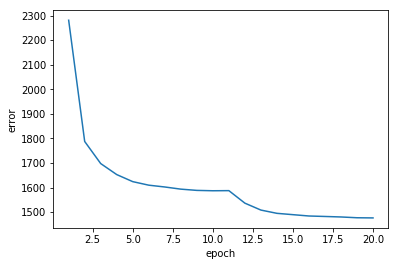

It takes 43.3336451054 seconds
The error: 607322.0



In [35]:
train_cl(8000, 100, 20, num_incs=10, learning_rate=16, approx_loss=True, use_sparse=True)

#dims increase by a factor of 1.99526231497
#red dims increase by 8.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 8.0


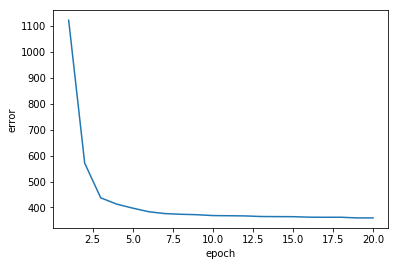

#dims: 79
reduce #dims to 28
svd error: 30338.3

Approximate loss with 42 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0


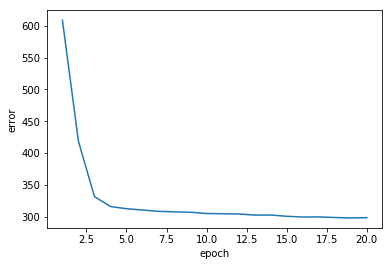

It takes 4.18127393723 seconds
The error: 30549.7

#dims: 157
reduce #dims to 36
svd error: 55748.5

Approximate loss with 54 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0


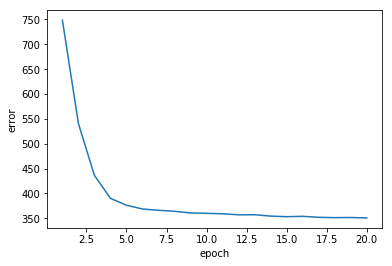

It takes 5.42090988159 seconds
The error: 55886.2

#dims: 313
reduce #dims to 44
svd error: 93787.5

Approximate loss with 66 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 16.0


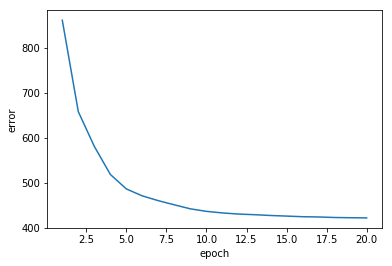

It takes 6.93371701241 seconds
The error: 94518.9

#dims: 624
reduce #dims to 52
svd error: 150788.0

Approximate loss with 78 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0


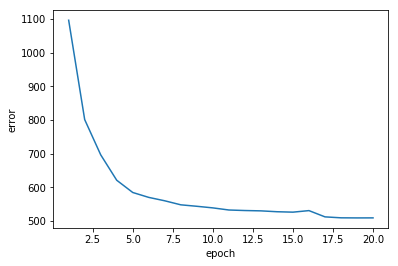

It takes 9.16647100449 seconds
The error: 151487.0

#dims: 1245
reduce #dims to 60
svd error: 235481.0

Approximate loss with 90 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0


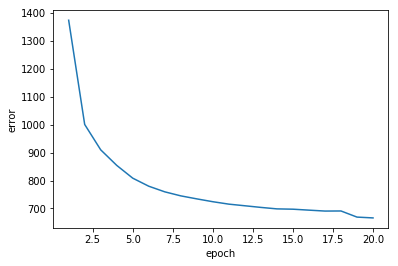

It takes 13.6758389473 seconds
The error: 237124.0

#dims: 2484
reduce #dims to 68
svd error: 345110.0

Approximate loss with 102 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 32.0


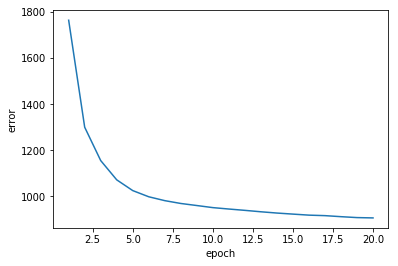

It takes 18.128164053 seconds
The error: 348482.0

#dims: 4956
reduce #dims to 76
svd error: 495266.0

Approximate loss with 114 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 64.0


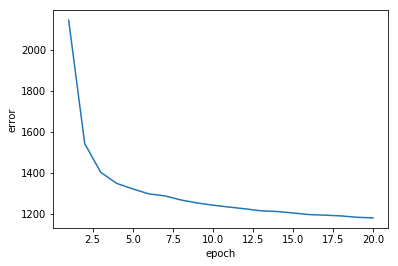

It takes 29.0903279781 seconds
The error: 500076.0

#dims: 9888
reduce #dims to 84
svd error: 709902.0

Approximate loss with 126 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0


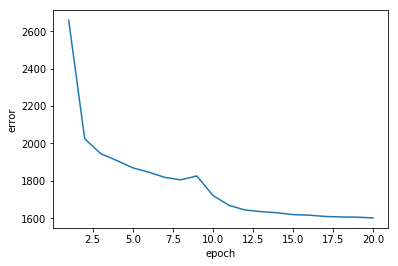

It takes 48.6472921371 seconds
The error: 715771.0

#dims: 19729
reduce #dims to 92
svd error: 965238.0

Approximate loss with 138 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0


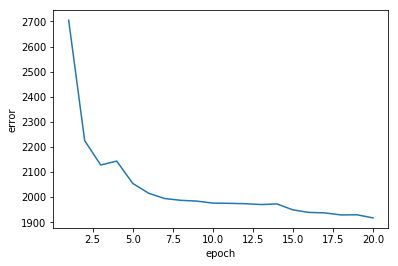

It takes 85.2694201469 seconds
The error: 970830.0

#dims: 39364
reduce #dims to 100
svd error: 1.22032e+06

Approximate loss with 150 dims
Train from previous results
Use sparse operators
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 20
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0


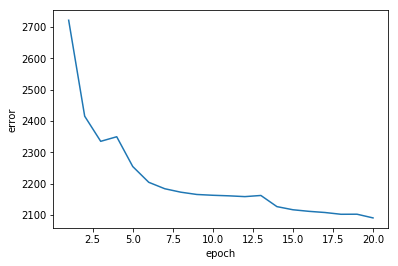

It takes 159.370316029 seconds


MemoryError: 

In [36]:
train_cl(40000, 100, 20, num_incs=10, learning_rate=16, approx_loss=True, use_sparse=True)

Below are experiments that don't approximate loss. They take much longer time to train and end up with a much larger loss.

#dims increase by a factor of 1.14163099142
#red dims increase by 2.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 7.25694394112 seconds
The error: 14494.8


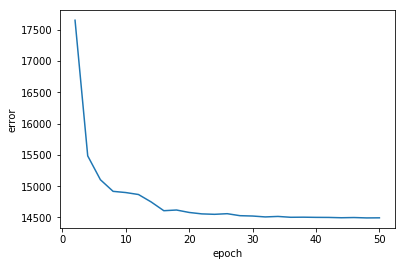

#dims: 45
reduce #dims to 22
svd error: 15658.7

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 7.911039114 seconds
The error: 15679.9


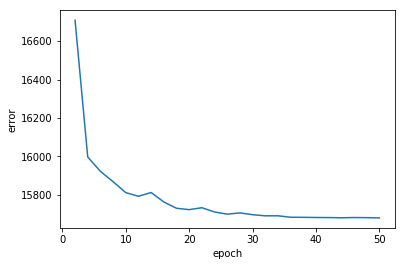

#dims: 51
reduce #dims to 24
svd error: 17505.5

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 8.34819793701 seconds
The error: 17607.9


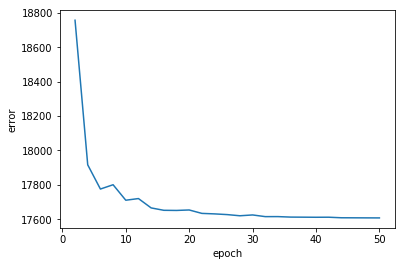

#dims: 58
reduce #dims to 26
svd error: 19876.2

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 10.1149969101 seconds
The error: 19941.0


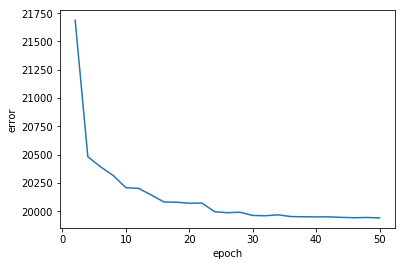

#dims: 66
reduce #dims to 28
svd error: 23086.2

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 10.2984600067 seconds
The error: 23147.2


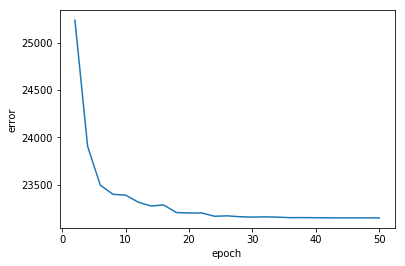

#dims: 75
reduce #dims to 30
svd error: 25858.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 11.8584370613 seconds
The error: 25905.2


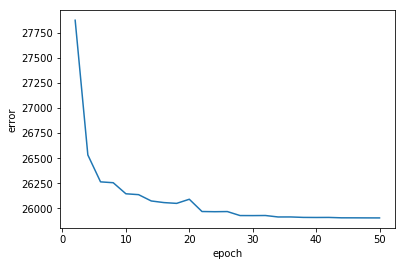

#dims: 85
reduce #dims to 32
svd error: 29855.3

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
It takes 13.8675870895 seconds
The error: 29938.0


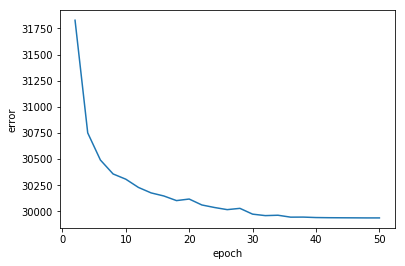

#dims: 97
reduce #dims to 34
svd error: 33382.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 15.9415650368 seconds
The error: 33554.7


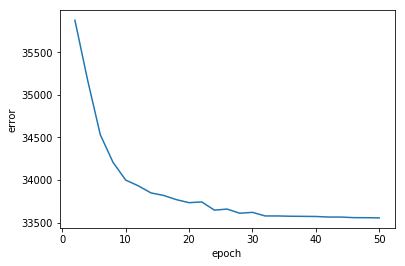

#dims: 110
reduce #dims to 36
svd error: 37653.6

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 18.4537651539 seconds
The error: 37797.3


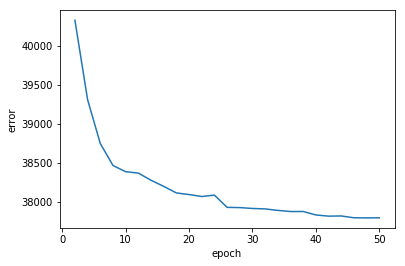

#dims: 125
reduce #dims to 38
svd error: 42048.5

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 19.8307318687 seconds
The error: 42208.7


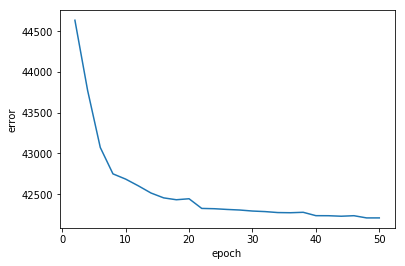

#dims: 142
reduce #dims to 40
svd error: 47232.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 21.6438949108 seconds
The error: 47390.8


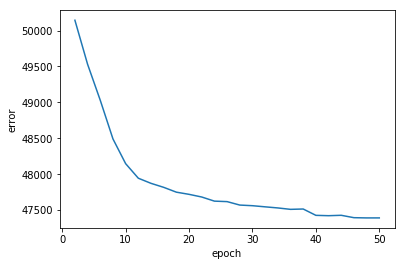

#dims: 162
reduce #dims to 42
svd error: 52506.3

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 25.3908779621 seconds
The error: 52689.6


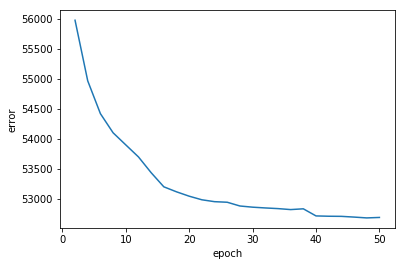

#dims: 184
reduce #dims to 44
svd error: 57972.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 28.5793819427 seconds
The error: 58174.1


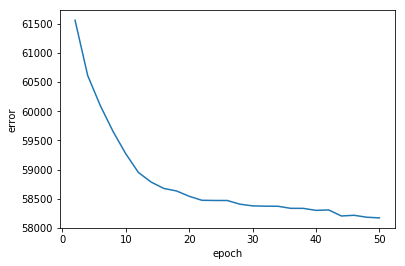

#dims: 210
reduce #dims to 46
svd error: 64194.7

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 34.1475310326 seconds
The error: 64487.5


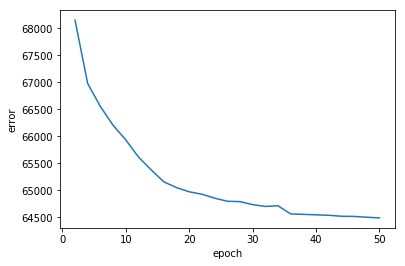

#dims: 239
reduce #dims to 48
svd error: 71096.4

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 16.0
It takes 36.9774229527 seconds
The error: 71516.8


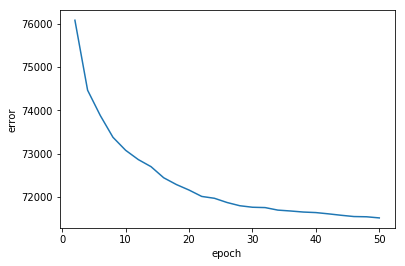

#dims: 272
reduce #dims to 50
svd error: 78701.9

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 38.314593792 seconds
The error: 78923.6


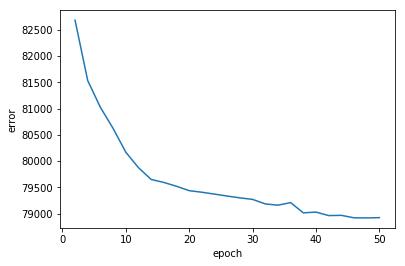

#dims: 310
reduce #dims to 52
svd error: 85999.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 43.5981988907 seconds
The error: 86360.3


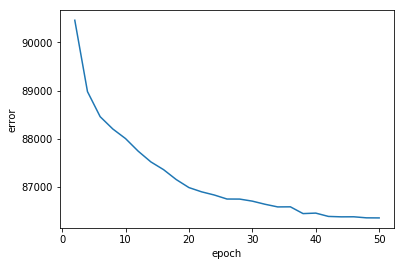

#dims: 353
reduce #dims to 54
svd error: 94736.9

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
It takes 48.6569440365 seconds
The error: 96049.8


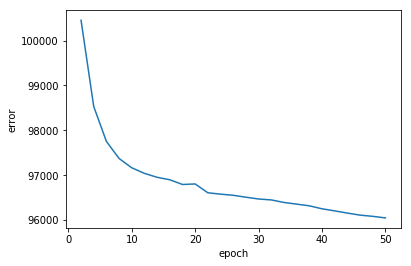

#dims: 402
reduce #dims to 56
svd error: 104708.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 32.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 32.0
It takes 55.0708549023 seconds
The error: 105789.0


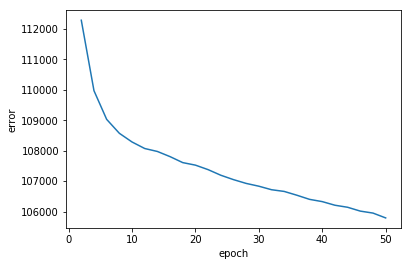

#dims: 458
reduce #dims to 58
svd error: 114799.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 61.3157410622 seconds
The error: 115938.0


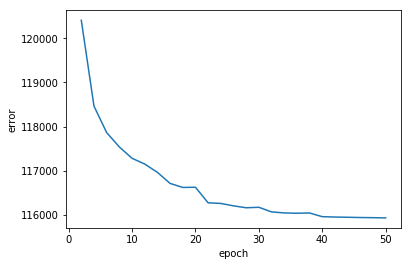

#dims: 522
reduce #dims to 60
svd error: 125318.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 71.0020358562 seconds
The error: 127866.0


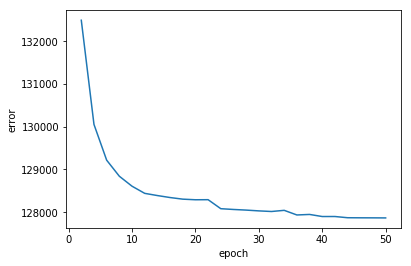

#dims: 595
reduce #dims to 62
svd error: 138381.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
It takes 80.1673030853 seconds
The error: 141897.0


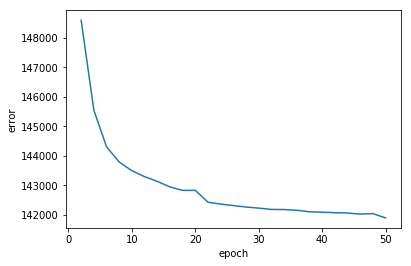

#dims: 679
reduce #dims to 64
svd error: 151308.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
reinit optimizer. New learning rate: 16.0
It takes 86.0846300125 seconds
The error: 155666.0


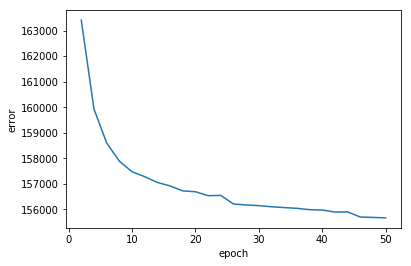

#dims: 775
reduce #dims to 66
svd error: 165031.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 64.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 64.0
It takes 100.688035011 seconds
The error: 170047.0


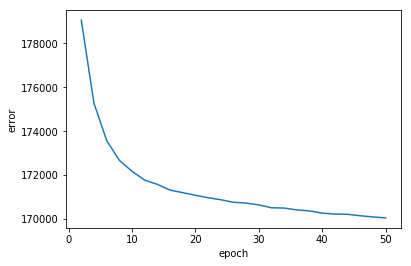

#dims: 884
reduce #dims to 68
svd error: 181194.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
It takes 113.445956945 seconds
The error: 185394.0


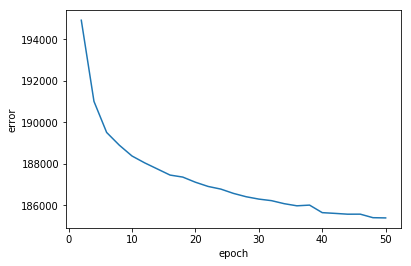

#dims: 1009
reduce #dims to 70
svd error: 196638.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
It takes 131.059556007 seconds
The error: 201623.0


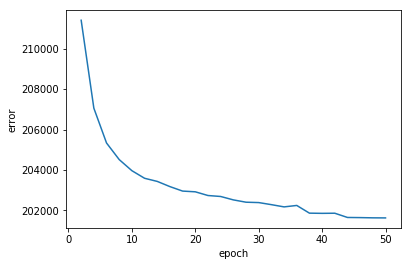

#dims: 1151
reduce #dims to 72
svd error: 212816.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
reinit optimizer. New learning rate: 32.0
It takes 146.00284481 seconds
The error: 219679.0


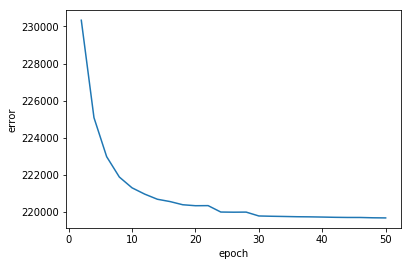

#dims: 1314
reduce #dims to 74
svd error: 229402.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
It takes 167.637413025 seconds
The error: 238148.0


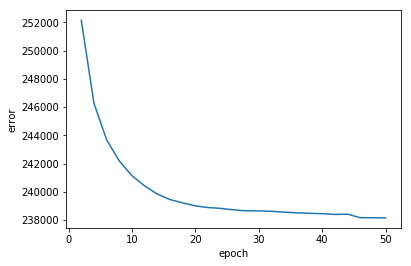

#dims: 1500
reduce #dims to 76
svd error: 247765.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
It takes 190.88003993 seconds
The error: 258060.0


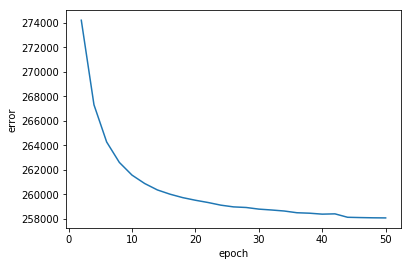

#dims: 1712
reduce #dims to 78
svd error: 267604.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 128.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 128.0
It takes 220.314502001 seconds
The error: 280322.0


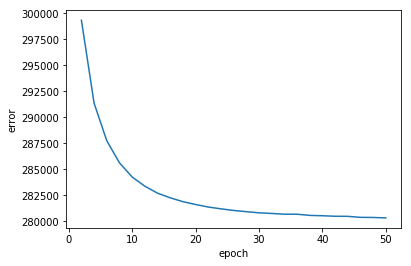

#dims: 1954
reduce #dims to 80
svd error: 288534.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 256.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 256.0
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
It takes 249.706595898 seconds
The error: 303056.0


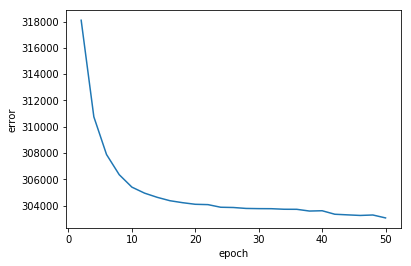

#dims: 2230
reduce #dims to 82
svd error: 310099.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 256.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 256.0
reinit optimizer. New learning rate: 128.0
reinit optimizer. New learning rate: 64.0
It takes 291.844092846 seconds
The error: 327540.0


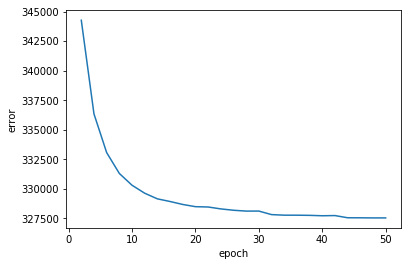

#dims: 2545
reduce #dims to 84
svd error: 333507.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 256.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 256.0
It takes 337.663317204 seconds
The error: 354710.0


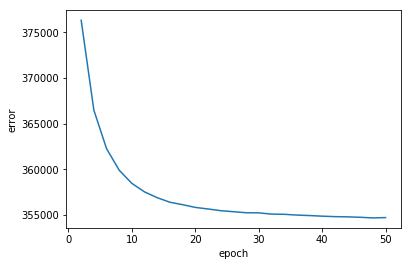

#dims: 2905
reduce #dims to 86
svd error: 358536.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 256.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 256.0
It takes 411.073120117 seconds
The error: 382734.0


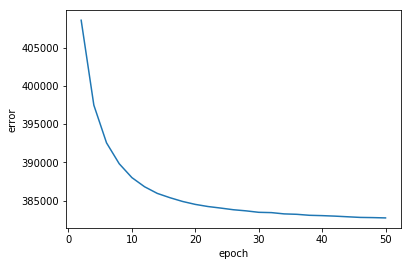

#dims: 3316
reduce #dims to 88
svd error: 384816.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 512.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 512.0
It takes 435.537147045 seconds
The error: 411344.0


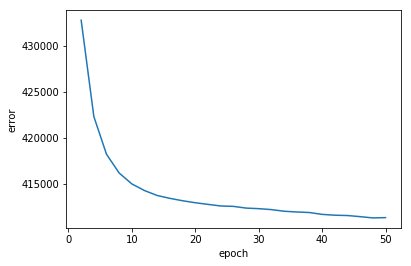

#dims: 3785
reduce #dims to 90
svd error: 414046.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 512.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 512.0
reinit optimizer. New learning rate: 256.0
It takes 532.863912821 seconds
The error: 443659.0


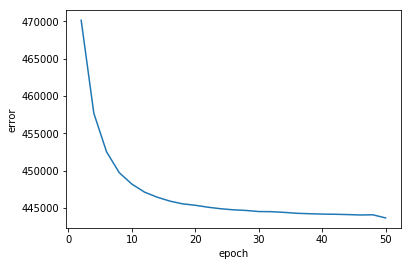

#dims: 4321
reduce #dims to 92
svd error: 443092.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 512.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 512.0
reinit optimizer. New learning rate: 256.0
It takes 570.255192041 seconds
The error: 477437.0


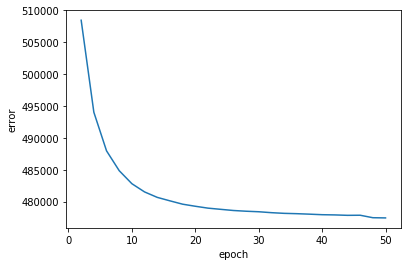

#dims: 4932
reduce #dims to 94
svd error: 473047.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 512.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 512.0
It takes 676.398443937 seconds
The error: 513371.0


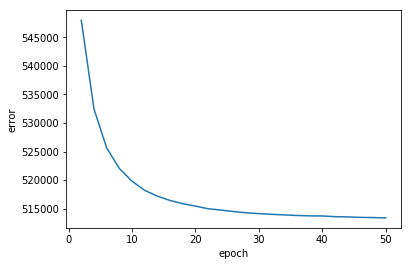

#dims: 5630
reduce #dims to 96
svd error: 507399.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 1024.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 1024.0
reinit optimizer. New learning rate: 512.0
It takes 752.790543079 seconds
The error: 552729.0


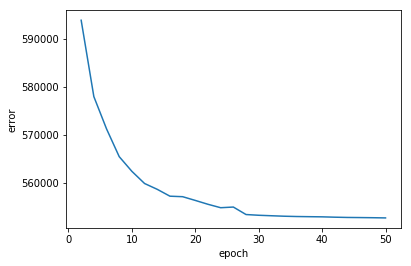

#dims: 6427
reduce #dims to 98
svd error: 549188.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 1024.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 1024.0
reinit optimizer. New learning rate: 512.0
It takes 955.161025047 seconds
The error: 601441.0


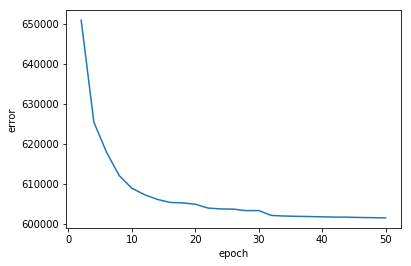

#dims: 7337
reduce #dims to 100
svd error: 584708.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 1024.0
batch size: 2000
internal #epochs: 50
reinit optimizer. New learning rate: 1024.0
reinit optimizer. New learning rate: 512.0
It takes 1031.35050011 seconds
The error: 643534.0


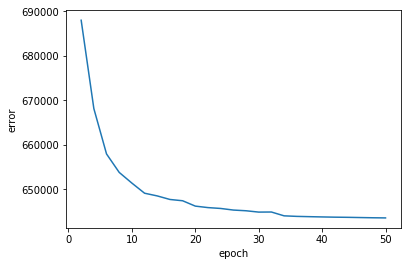

In [24]:
train_cl(8000, 100, 50, num_incs=40, learning_rate=16.0)

#dims increase by a factor of 1.69864646463
#red dims increase by 8.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
reinit optimizer. New learning rate: 0.125
reinit optimizer. New learning rate: 0.0625
It takes 14.6891829967 seconds
The error: 14525.4


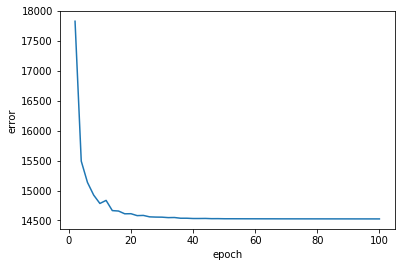

#dims: 67
reduce #dims to 28
svd error: 23735.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 22.599545002 seconds
The error: 23866.6


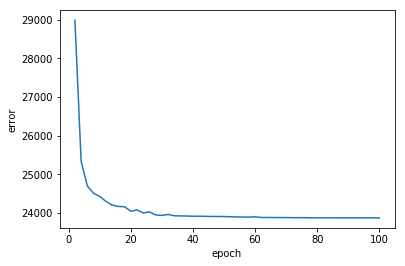

#dims: 113
reduce #dims to 36
svd error: 38571.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
reinit optimizer. New learning rate: 0.25
It takes 35.4165098667 seconds
The error: 38698.2


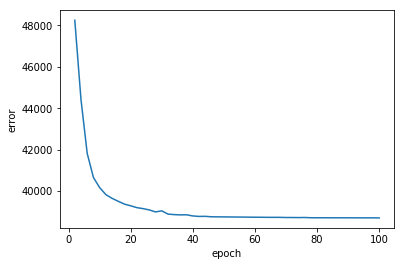

#dims: 191
reduce #dims to 44
svd error: 60142.5

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
reinit optimizer. New learning rate: 1.0
reinit optimizer. New learning rate: 0.5
It takes 57.7990870476 seconds
The error: 60297.5


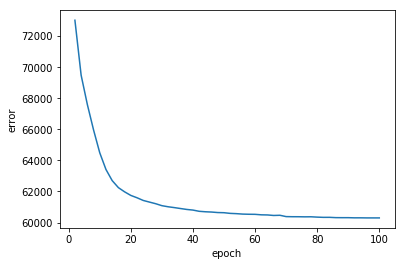

#dims: 324
reduce #dims to 52
svd error: 89254.4

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 92.1139090061 seconds
The error: 90452.6


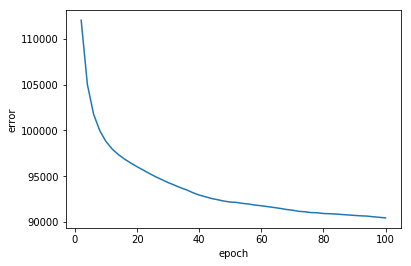

#dims: 550
reduce #dims to 60
svd error: 130925.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 152.147555828 seconds
The error: 136427.0


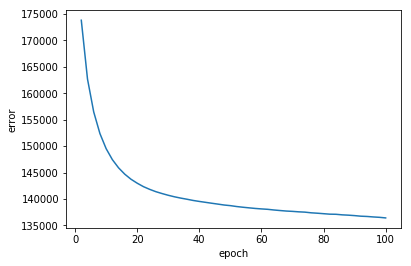

#dims: 934
reduce #dims to 68
svd error: 187582.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 240.725842953 seconds
The error: 201034.0


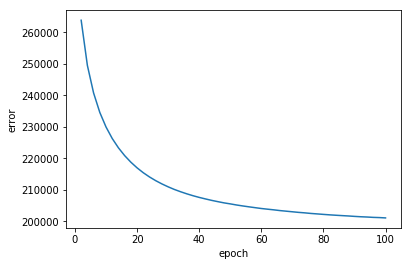

#dims: 1586
reduce #dims to 76
svd error: 256351.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 414.941539049 seconds
The error: 287537.0


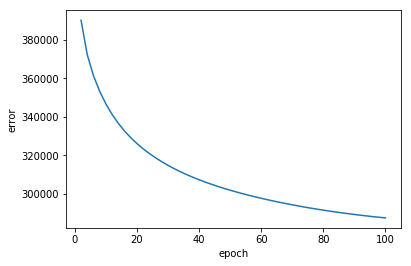

#dims: 2694
reduce #dims to 84
svd error: 343787.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 730.409393072 seconds
The error: 416397.0


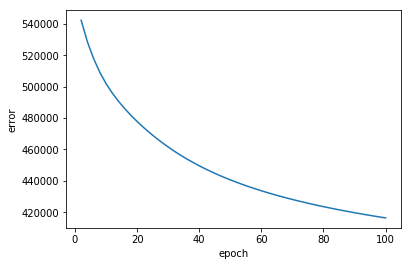

#dims: 4576
reduce #dims to 92
svd error: 458074.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 1320.96324396 seconds
The error: 613252.0


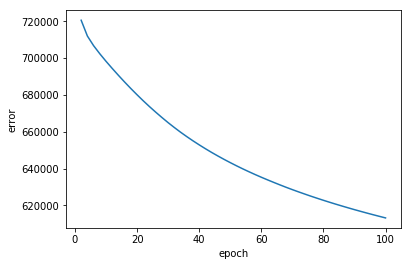

#dims: 7773
reduce #dims to 100
svd error: 602304.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 100
reinit optimizer. New learning rate: 16.0
It takes 2399.38668704 seconds
The error: 861957.0


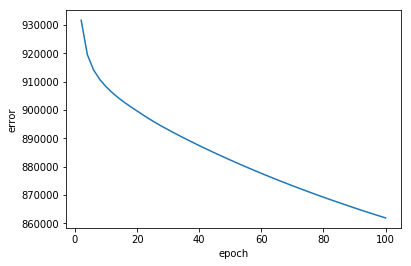

In [30]:
train_cl(8000, 100, 100, num_incs=10, learning_rate=16.0, lr_inc=1)

#dims increase by a factor of 1.14163099142
#red dims increase by 2.0
#dims: 40
reduce #dims to 20
svd error: 14468.5
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 8.0
It takes 3.38410592079 seconds
The error: 14541.1


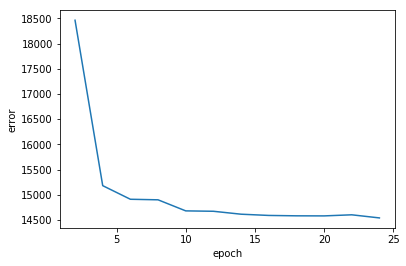

#dims: 45
reduce #dims to 22
svd error: 15658.7

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 3.93290090561 seconds
The error: 15739.9


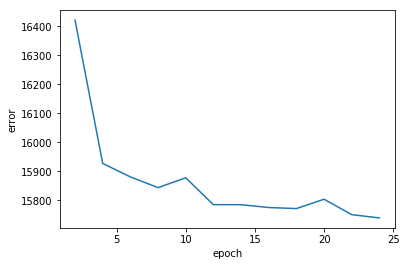

#dims: 51
reduce #dims to 24
svd error: 17505.5

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
reinit optimizer. New learning rate: 2.0
It takes 3.92802906036 seconds
The error: 17610.2


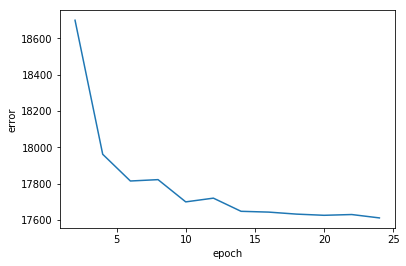

#dims: 58
reduce #dims to 26
svd error: 19876.2

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 4.75435495377 seconds
The error: 20008.0


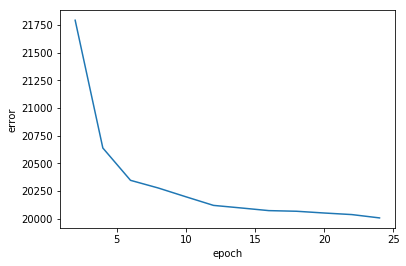

#dims: 66
reduce #dims to 28
svd error: 23086.2

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
reinit optimizer. New learning rate: 4.0
It takes 5.20467591286 seconds
The error: 23168.0


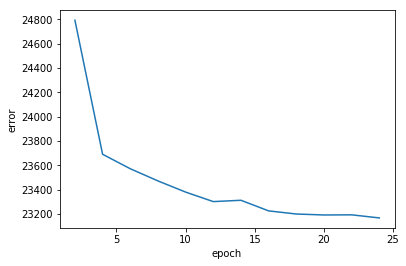

#dims: 75
reduce #dims to 30
svd error: 25858.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 5.79121184349 seconds
The error: 26056.0


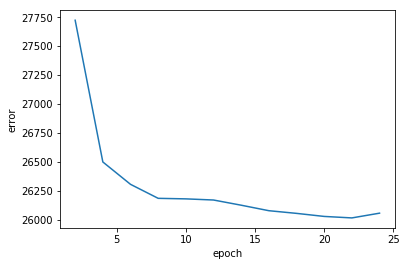

#dims: 85
reduce #dims to 32
svd error: 29855.3

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 6.12411999702 seconds
The error: 30048.5


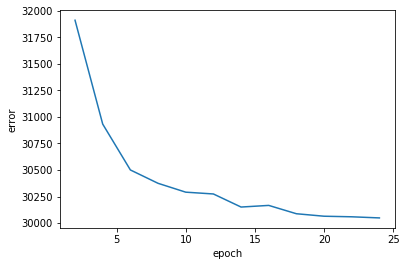

#dims: 97
reduce #dims to 34
svd error: 33382.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 6.77587413788 seconds
The error: 33597.5


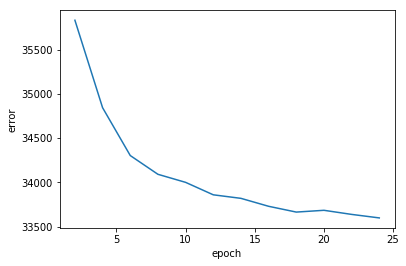

#dims: 110
reduce #dims to 36
svd error: 37653.6

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
reinit optimizer. New learning rate: 8.0
It takes 10.2090530396 seconds
The error: 38001.3


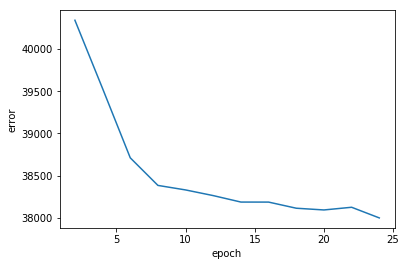

#dims: 125
reduce #dims to 38
svd error: 42048.5

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 9.90676307678 seconds
The error: 42548.5


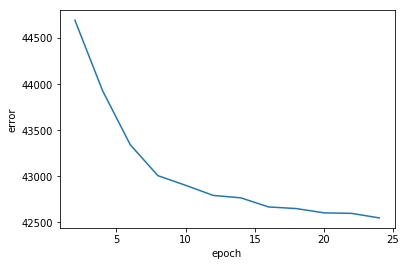

#dims: 142
reduce #dims to 40
svd error: 47232.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 10.2831470966 seconds
The error: 47691.3


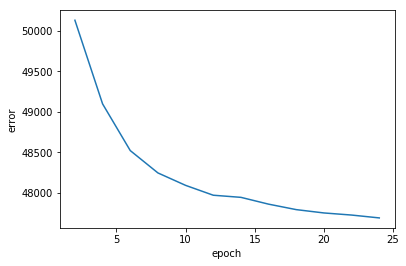

#dims: 162
reduce #dims to 42
svd error: 52506.3

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 12.5358920097 seconds
The error: 52932.8


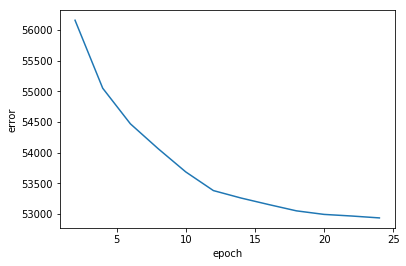

#dims: 184
reduce #dims to 44
svd error: 57972.8

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 12.9115929604 seconds
The error: 58545.5


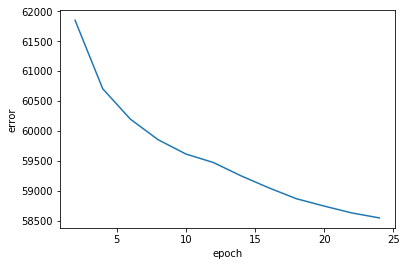

#dims: 210
reduce #dims to 46
svd error: 64194.6

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 16.5663249493 seconds
The error: 64937.0


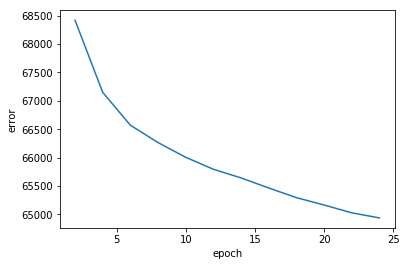

#dims: 239
reduce #dims to 48
svd error: 71096.4

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 16.5912599564 seconds
The error: 72309.9


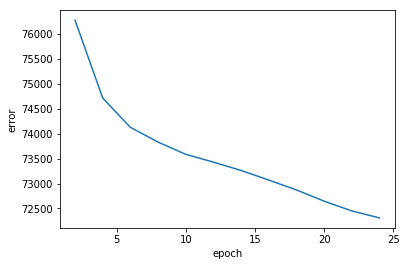

#dims: 272
reduce #dims to 50
svd error: 78701.9

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 18.9859731197 seconds
The error: 80222.1


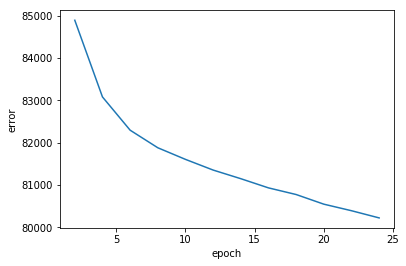

#dims: 310
reduce #dims to 52
svd error: 85999.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 21.4227380753 seconds
The error: 87807.1


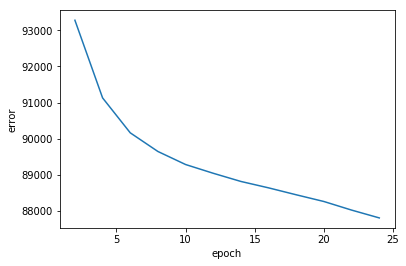

#dims: 353
reduce #dims to 54
svd error: 94736.9

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 25.4835059643 seconds
The error: 97337.7


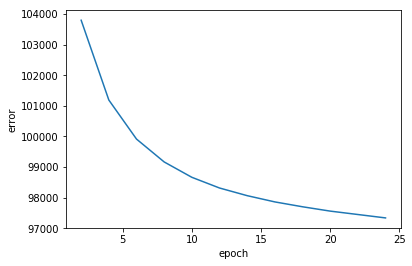

#dims: 402
reduce #dims to 56
svd error: 104708.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 28.0713269711 seconds
The error: 108563.0


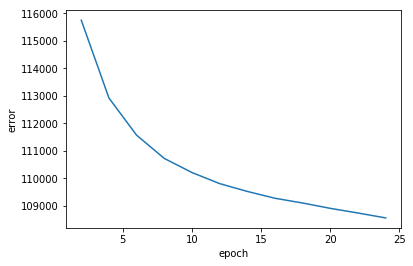

#dims: 458
reduce #dims to 58
svd error: 114799.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 30.631455183 seconds
The error: 119328.0


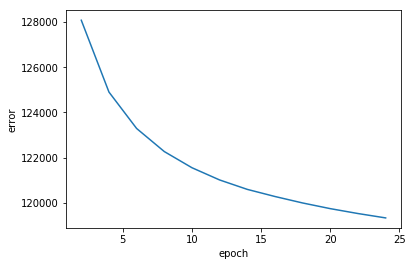

#dims: 522
reduce #dims to 60
svd error: 125318.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 34.8658721447 seconds
The error: 131236.0


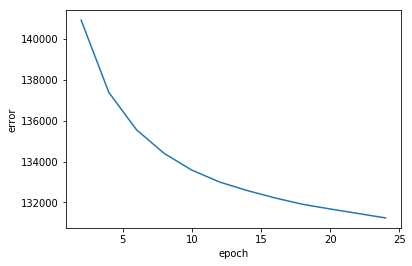

#dims: 595
reduce #dims to 62
svd error: 138381.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 39.556607008 seconds
The error: 146049.0


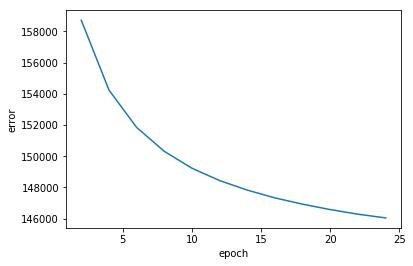

#dims: 679
reduce #dims to 64
svd error: 151308.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 46.3261358738 seconds
The error: 160992.0


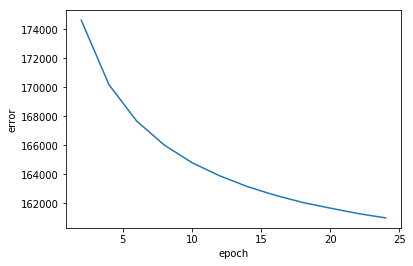

#dims: 775
reduce #dims to 66
svd error: 165031.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 48.1175711155 seconds
The error: 176837.0


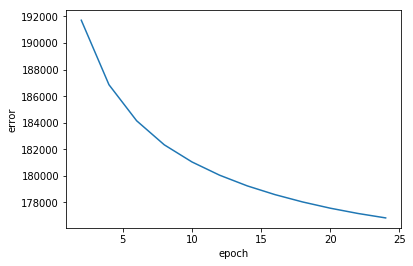

#dims: 884
reduce #dims to 68
svd error: 181194.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 54.7420420647 seconds
The error: 196302.0


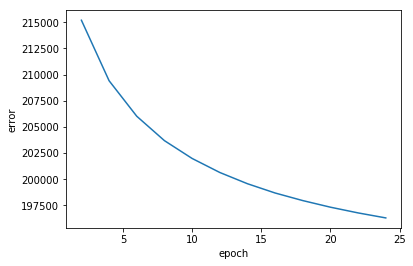

#dims: 1009
reduce #dims to 70
svd error: 196638.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 62.1714129448 seconds
The error: 216068.0


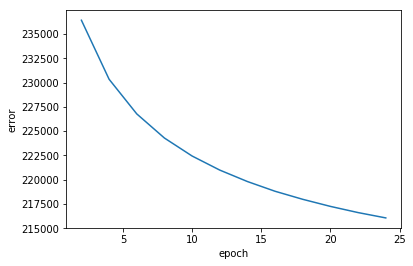

#dims: 1151
reduce #dims to 72
svd error: 212816.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 70.4425230026 seconds
The error: 236733.0


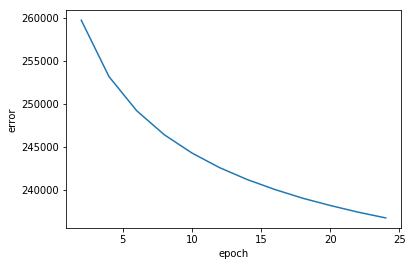

#dims: 1314
reduce #dims to 74
svd error: 229402.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 82.7104279995 seconds
The error: 259859.0


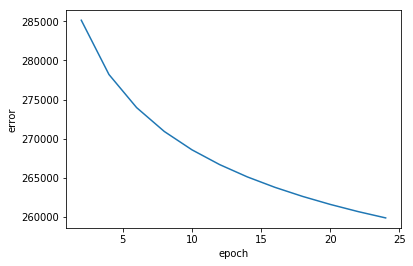

#dims: 1500
reduce #dims to 76
svd error: 247765.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 94.5401699543 seconds
The error: 285301.0


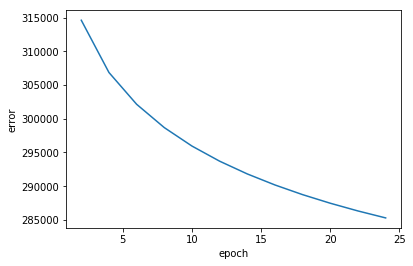

#dims: 1712
reduce #dims to 78
svd error: 267604.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 107.199208975 seconds
The error: 313957.0


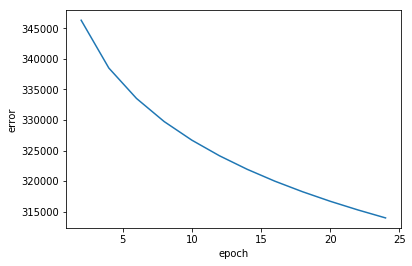

#dims: 1954
reduce #dims to 80
svd error: 288534.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 126.454988003 seconds
The error: 343665.0


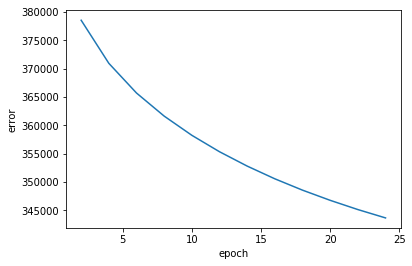

#dims: 2230
reduce #dims to 82
svd error: 310099.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 145.920988083 seconds
The error: 375500.0


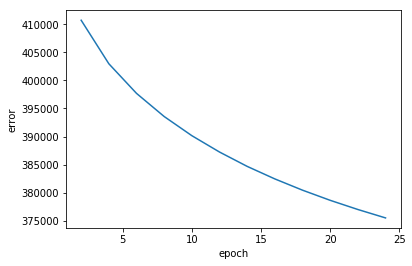

#dims: 2545
reduce #dims to 84
svd error: 333507.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 167.008342028 seconds
The error: 414370.0


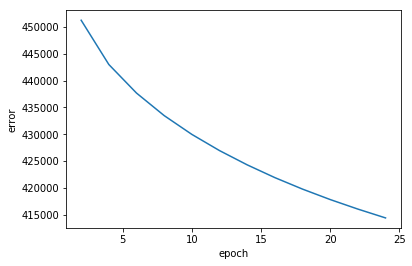

#dims: 2905
reduce #dims to 86
svd error: 358536.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 192.979897022 seconds
The error: 455739.0


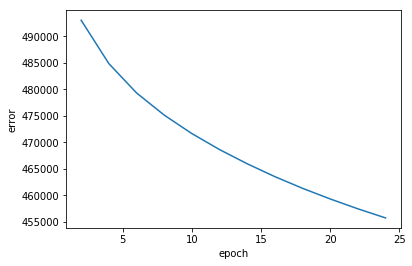

#dims: 3316
reduce #dims to 88
svd error: 384816.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 235.047395229 seconds
The error: 500392.0


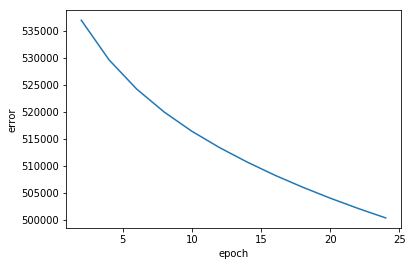

#dims: 3785
reduce #dims to 90
svd error: 414046.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 251.991185188 seconds
The error: 551156.0


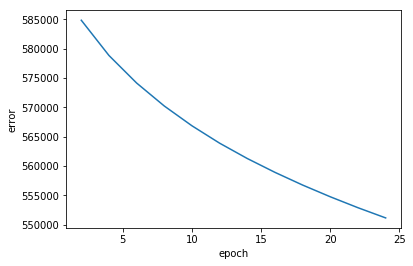

#dims: 4321
reduce #dims to 92
svd error: 443092.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 295.78944993 seconds
The error: 602087.0


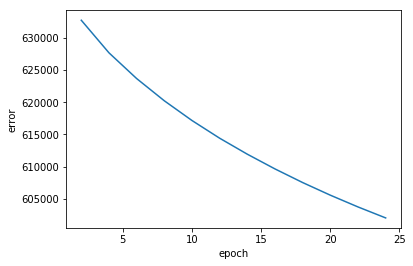

#dims: 4932
reduce #dims to 94
svd error: 473047.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 337.044671059 seconds
The error: 654685.0


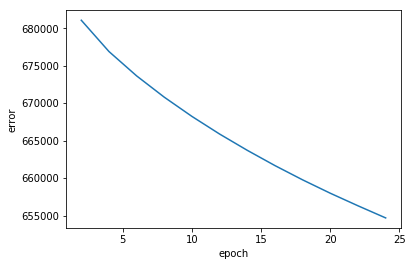

#dims: 5630
reduce #dims to 96
svd error: 507399.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 370.3117311 seconds
The error: 712108.0


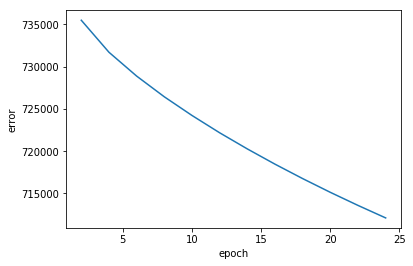

#dims: 6427
reduce #dims to 98
svd error: 549188.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 447.086448908 seconds
The error: 785009.0


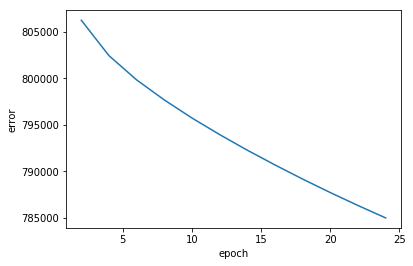

#dims: 7337
reduce #dims to 100
svd error: 584708.0

Train from previous results
Internal activation: relu
loss func: L2
Learning rate: 16.0
batch size: 2000
internal #epochs: 25
reinit optimizer. New learning rate: 16.0
It takes 500.328689098 seconds
The error: 843839.0


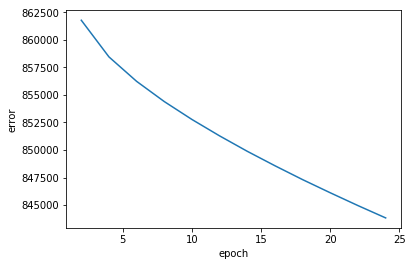

In [31]:
train_cl(8000, 100, 25, num_incs=40, learning_rate=16.0, lr_inc=1)

In [ ]:
pref_matrix = [[0.9, 0.1], [0.1, 0.9]]
block_sizes = [70, 30]
g = ig.Graph.SBM(100, pref_matrix, block_sizes, directed=True)
sim_spm = g.get_adjacency()